In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import celllist as cl
import verlet as vl
import pse
import particles as p

In [2]:
def applyBrusselator(u, v, a, b, k):
    du = a + k*(u**2)*v - (b + 1)*u
    dv = b*u - k*(u**2)*v
    return du, dv

def solveODE(u, v, a, b, k, dt = 0.01, T = 20):
    T_steps = np.arange(0, T, dt)
    u_t = np.zeros(len(T_steps))
    v_t = np.zeros(len(T_steps))
    for i, t in enumerate(T_steps):
        du, dv = applyBrusselator(u, v, a, b, k)
        u = u + du * dt
        v = v + dv * dt
        u_t[i] = u
        v_t[i] = v
    return u_t, v_t, T_steps

In [3]:
u_t, v_t, t = solveODE(0.7, 0.04, 2, 6, 1)

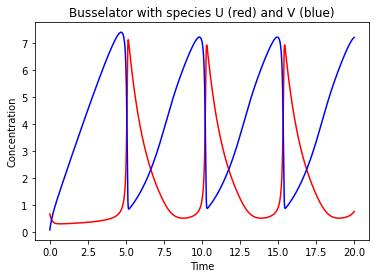

In [4]:
plt.plot(t, u_t, color="red")
plt.plot(t, v_t, color="blue")
plt.xlabel(r"Time")
plt.ylabel(r"Concentration")
plt.title(r"Busselator with species U (red) and V (blue)")
plt.show()

### Part 2: Couple the Brusselator with Diffusion

In [5]:
def initializeParticles(numParticles, u0, v0):
    u = np.full(numParticles, u0)
    v = np.full(numParticles, v0)
    
    return np.vstack((u, v)).T

def initializeRandomParticles(numParticles, offset):
    u = np.random.uniform(0, 1, numParticles)
    v = np.random.uniform(0, 1, numParticles) + offset
    
    return np.vstack((u, v)).T

In [6]:
# Particle settings
N = 51
numParticles = N**2
lBounds, uBounds = 0, 81
dim, kind = 2, 1
h = (uBounds-lBounds)/(N)
epsilon = h
cutoff = 3*epsilon
cellSide = cutoff
offset = 7
numStren = 2

# Couple with diffusion
a, b, k, D = 1, 1.7, 1, 10
T = 10
dt = 0.01
t = 0
# All particles have same volume
V = h**2

bW = np.round(cutoff/h)

In [7]:
particlePos = p.createParticles(numParticles,dim,lBounds,uBounds,kind)
particleStrength = initializeRandomParticles(numParticles, 0)

particleMat,cellList,numCells = cl.createCellList(particlePos,lBounds,uBounds,cellSide)
verletList = vl.createVerletList(particleMat,cellList,numCells,cutoff)

particleMat = np.hstack((particleMat, particleStrength))

In [8]:
%matplotlib qt5
plt.rcParams["figure.figsize"] = (5, 5)

In [9]:
import time
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.canvas.draw()

X = particleMat[:,0].reshape((N, N))
Y = particleMat[:,1].reshape((N, N))

while True:
    # Run the PSE
    pseSum = pse.applyPSE(particleMat,verletList,epsilon,numStren, dim)

    # Run the Brusselator
    br = np.array(applyBrusselator(particleMat[:,dim+1], particleMat[:,dim+2], a, b, k)).T
    
    # Apply for all strengths
    particleMat[:,(dim+1):] = particleMat[:,(dim+1):] + (pseSum*V*D/(epsilon**2) + br)*dt 

    # Apply periodic boundary conditions
    tempMat = particleMat[:,(dim+1):].reshape((N,N,-1))
    tempMat = pse.periodicBoundaries(tempMat,h,cutoff,bW,N,N)
    particleMat[:,(dim+1):] = tempMat.reshape((numParticles, numStren))
    
    # Concentration across space plot
    U=particleMat[:,dim+1].reshape((N, N))
    ax.clear()
    ax.pcolormesh(X,Y,U, cmap = "RdBu")
    ax.set_title("t = {:0.2f} s".format(t))
    fig.canvas.draw()
    plt.pause(0.001)
    
    # Update the time step
    t += dt

KeyboardInterrupt: 